In [2]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir


In [3]:
class particle:
    def __init__(self,ievt, index, pid, Xf, Zh, PhiPQ, ThetaPQ, Pt, Nu, W):
        self.pid = pid
        self.Zh = Zh
        self.Xf = Xf
        self.ievt = ievt
        self.index = index
        self.PhiPQ = PhiPQ*np.pi/180.0
        self.ThetaPQ = ThetaPQ*np.pi/180.0
        self.Nu = Nu
        self.W  = W
        self.E = self.Nu*self.Zh
        self.Eta = -1.0*np.log(np.tan(0.5*self.ThetaPQ))
        self.Pt = Pt
        self.P = np.sqrt(self.E*self.E - 0.139*0.139)
        self.Pl = self.Xf*self.W/2.0
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl))
        self.LorentzVector = ROOT.TLorentzVector()
        
    def print_properties(self):
        print 'Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W
        print 'zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y
        print 'pid = ' , self.pid

In [4]:

def getDataframes(filename, Target=1,maxevents=1e9):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('tree_data')
    e_tree = myfile.Get('e_rec')
    
    
    print filename, ' has ', mytree.GetEntries(), ' entries'
    tupla = {}
    tupla['dphi'] = []
    tupla['dy'] = []
    tupla['z'] = [] 
    tupla['z_asso'] = []
    tupla['xf'] = []
    tupla['xf_asso'] = []
    tupla['y'] = []
    tupla['y_asso'] = []
    tupla['pid'] = []
    tupla['pid_asso'] = []
    tupla['phi_pq'] = []
    tupla['phi_pq_asso'] = []
    tupla['mass'] = []
    tupla['missing_mass'] = []

    tupla_mix = {}
    tupla_mix['dphi'] = []
    tupla_mix['dy'] = []
    tupla_mix['z'] = []
    tupla_mix['z_asso'] = []
    tupla_mix['xf'] = []
    tupla_mix['xf_asso'] = []
    tupla_mix['y'] = []
    tupla_mix['y_asso'] = []
    tupla_mix['pid'] = []
    tupla_mix['pid_asso'] = []
    tupla_mix['phi_pq']   = []
    tupla_mix['phi_pq_asso'] = []
    tupla_mix['mass'] = []
    tupla_mix['missing_mass'] = []

    tupla_trigger = {}
    tupla_trigger['xf'] = []
    tupla_trigger['z']  = []
    tupla_trigger['y']  = []
    tupla_trigger['phi_pq'] = []
    tupla_trigger['TargType'] = []
    tupla_trigger['mass'] = []

    tupla_pi0 = {}
    tupla_pi0['z'] = []
    tupla_pi0['mass'] = []



    start = time.time()

    for ievt  in range(mytree.GetEntries()):
        mytree.GetEntry(ievt)   
        e_tree.GetEntry(ievt)
        if mytree.W<2.05 or mytree.Q2<1.0: continue
        if ievt>maxevents: break
        if mytree.TargType!=Target: continue

        #get electron momentum:
        Pe = np.sqrt(e_tree.Pex*e_tree.Pex + e_tree.Pey*e_tree.Pey+ e_tree.Pez*e_tree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(e_tree.Pex, e_tree.Pey, e_tree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        
        W = mytree.W
        Nu = mytree.Nu
        #print 'W ',  W , 'electron W ', e_tree.W
        #print (virtual_photon + proton).M()
        
        particles = []
        
       
        #print ' Entering main loop over particles'
        for i in range(len(mytree.pid)):
            if abs(mytree.pid[i]) !=211: continue
            i_part = particle(ievt, i,mytree.pid[i], mytree.Xf[i],mytree.Zh[i], mytree.PhiPQ[i], mytree.ThetaPQ[i],mytree.Pt[i],Nu,W)
            particles.append(i_part)                
            i_part.LorentzVector.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu)
            
            tupla_trigger['TargType'].append(mytree.TargType)
            tupla_trigger['xf'].append(i_part.Xf)
            tupla_trigger['z'].append(i_part.Zh)
            tupla_trigger['y'].append(i_part.y)
            tupla_trigger['phi_pq'].append(i_part.PhiPQ)
            tupla_trigger['mass'].append(i_part.LorentzVector.M())
            
            for j in range(len(mytree.pid)): 
                if i==j: continue
                if abs(mytree.pid[j]) !=211: continue
                j_part = particle(ievt, j,mytree.pid[j], mytree.Xf[j],mytree.Zh[j], mytree.PhiPQ[j], mytree.ThetaPQ[j],mytree.Pt[j],Nu,W)
                particles.append(j_part)                
                j_part.LorentzVector.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)  

                dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                dy = i_part.y-j_part.y
                deta = i_part.ThetaPQ - j_part.ThetaPQ
                ### FILLING CORRELATIONS

                dipion = i_part.LorentzVector+j_part.LorentzVector
                X = (virtual_photon + proton - dipion)
                tupla['dphi'].append(dphi)
                tupla['dy'].append(dy)
                tupla['z'].append(i_part.Zh)
                tupla['z_asso'].append(j_part.Zh)
                tupla['xf'].append(i_part.Xf)
                tupla['xf_asso'].append(j_part.Xf)
                tupla['y'].append(i_part.y)
                tupla['y_asso'].append(j_part.y)
                tupla['pid'].append(i_part.pid)
                tupla['pid_asso'].append(j_part.pid)
                tupla['phi_pq'].append(i_part.PhiPQ)
                tupla['phi_pq_asso'].append(j_part.PhiPQ)
                tupla['mass'].append(dipion.M())
                tupla['missing_mass'].append(X.M())
                
                #end loop over secondary loop    
            #print '//////// Entering mixed event correlations with # ', len(ParticlesFromPrevious) , ' paticles in previous event'
            if i_part.Zh > 0.4: #do mixing
                for mixparticle in ParticlesFromPrevious:
                    dipion = i_part.LorentzVector+mixparticle.LorentzVector
                    X = (virtual_photon + proton - dipion)

                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    dy = i_part.y-mixparticle.y
                    deta = i_part.ThetaPQ-mixparticle.ThetaPQ
                    tupla_mix['dphi'].append(dphi)
                    tupla_mix['dy'].append(dy)
                    tupla_mix['z'].append(i_part.Zh)
                    tupla_mix['z_asso'].append(mixparticle.Zh)
                    tupla_mix['xf'].append(i_part.Xf)
                    tupla_mix['xf_asso'].append(mixparticle.Xf)
                    tupla_mix['y'].append(i_part.y)
                    tupla_mix['y_asso'].append(mixparticle.y)
                    tupla_mix['pid'].append(i_part.pid)
                    tupla_mix['pid_asso'].append(mixparticle.pid)
                    tupla_mix['phi_pq'].append(i_part.PhiPQ)
                    tupla_mix['phi_pq_asso'].append(mixparticle.PhiPQ)
                    tupla_mix['mass'].append(dipion.M())
                    tupla_mix['missing_mass'].append(X.M())
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print 'Processed in',  end-start, 'seconds'
    
    df = pd.DataFrame(tupla)
    df_mix= pd.DataFrame(tupla_mix)
    df_trigger = pd.DataFrame(tupla_trigger)
    df_pi0 = pd.DataFrame(tupla_pi0)
    print 'Number of triggers with z>0.4,  ', df.query('z>0.4').shape[0]
    print 'Number of pairs with z>0.4, ' ,df_trigger.query('z>0.4').shape[0] 
    #print 'number of photon pairs' , df_pi0.shape[0]
    myfile.Close()
    return df, df_mix, df_trigger

In [5]:
df = {}

In [23]:
path = '/mnt/c/Users/marratia/Linux/Pb_data/'

Files = listdir(path) 
df['Pb'],df['Pb_mix'], df['Pb_trigger'] = [None,None,None]
df['D_Pb'],df['D_Pb_mix'], df['D_Pb_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['Pb'] = pd.concat([ df['Pb'], pairs])
    df['Pb_mix'] = pd.concat([ df['Pb_mix'], pairs_mix])
    df['Pb_trigger'] = pd.concat([ df['Pb_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_Pb'] = pd.concat([ df['D_Pb'], pairs])
    df['D_Pb_mix'] = pd.concat([ df['D_Pb_mix'], pairs_mix])
    df['D_Pb_trigger'] = pd.concat([ df['D_Pb_trigger'], trigger])

/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41762.root  has  200510  entries


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


Processed in 44.7992539406 seconds
Number of triggers with z>0.4,   919
Number of pairs with z>0.4,  4267
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41762.root  has  200510  entries
Processed in 109.754489183 seconds
Number of triggers with z>0.4,   4602
Number of pairs with z>0.4,  18764
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41763.root  has  190818  entries
Processed in 42.890609026 seconds
Number of triggers with z>0.4,   848
Number of pairs with z>0.4,  4064
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41763.root  has  190818  entries
Processed in 59.8660650253 seconds
Number of triggers with z>0.4,   4366
Number of pairs with z>0.4,  17829
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41765.root  has  23948  entries
Processed in 2.90163993835 seconds
Number of triggers with z>0.4,   100
Number of pairs with z>0.4,  525
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41765.root  has  23948  entries
Processed in 7.14507889748 seconds
Number of 

Processed in 59.088591814 seconds
Number of triggers with z>0.4,   4621
Number of pairs with z>0.4,  18914
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41809.root  has  194775  entries
Processed in 23.3160939217 seconds
Number of triggers with z>0.4,   872
Number of pairs with z>0.4,  4108
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41809.root  has  194775  entries
Processed in 56.9643301964 seconds
Number of triggers with z>0.4,   4522
Number of pairs with z>0.4,  18322
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41810.root  has  198405  entries
Processed in 23.77779603 seconds
Number of triggers with z>0.4,   885
Number of pairs with z>0.4,  4164
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41810.root  has  198405  entries
Processed in 58.2861700058 seconds
Number of triggers with z>0.4,   4649
Number of pairs with z>0.4,  18614
/mnt/c/Users/marratia/Linux/Pb_data/CFFTree_Pb_data_41811.root  has  200656  entries
Processed in 24.003993988 seconds
Number o

## Fe data

In [22]:
path = '/mnt/c/Users/marratia/Linux/Fe_data/'
Files = listdir(path) 
df['Fe'],df['Fe_mix'], df['Fe_trigger'] = [None,None,None]
df['D_Fe'],df['D_Fe_mix'], df['D_Fe_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['Fe'] = pd.concat([ df['Fe'], pairs])
    df['Fe_mix'] = pd.concat([ df['Fe_mix'], pairs_mix])
    df['Fe_trigger'] = pd.concat([ df['Fe_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_Fe'] = pd.concat([ df['D_Fe'], pairs])
    df['D_Fe_mix'] = pd.concat([ df['D_Fe_mix'], pairs_mix])
    df['D_Fe_trigger'] = pd.concat([ df['D_Fe_trigger'], trigger])

/mnt/c/Users/marratia/Linux/Fe_data/CFFTree_Fe_data_41146.root  has  220529  entries


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


Processed in 99.3498871326 seconds
Number of triggers with z>0.4,   2148
Number of pairs with z>0.4,  9525
/mnt/c/Users/marratia/Linux/Fe_data/CFFTree_Fe_data_41146.root  has  220529  entries
Processed in 93.383439064 seconds
Number of triggers with z>0.4,   3833
Number of pairs with z>0.4,  15127
/mnt/c/Users/marratia/Linux/Fe_data/CFFTree_Fe_data_41147.root  has  208300  entries
Processed in 77.8877699375 seconds
Number of triggers with z>0.4,   2122
Number of pairs with z>0.4,  9032
/mnt/c/Users/marratia/Linux/Fe_data/CFFTree_Fe_data_41147.root  has  208300  entries
Processed in 87.1199979782 seconds
Number of triggers with z>0.4,   3634
Number of pairs with z>0.4,  14653
/mnt/c/Users/marratia/Linux/Fe_data/CFFTree_Fe_data_41148.root  has  182293  entries
Processed in 85.1211769581 seconds
Number of triggers with z>0.4,   1905
Number of pairs with z>0.4,  7779
/mnt/c/Users/marratia/Linux/Fe_data/CFFTree_Fe_data_41148.root  has  182293  entries
Processed in 115.558456898 seconds
Numb

## C data

In [6]:
path = '/mnt/c/Users/marratia/Linux/C_data/'
Files = listdir(path) 
df['C'],df['C_mix'], df['C_trigger'] = [None,None,None]
df['D_C'],df['D_C_mix'], df['D_C_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['C'] = pd.concat([ df['C'], pairs])
    df['C_mix'] = pd.concat([ df['C_mix'], pairs_mix])
    df['C_trigger'] = pd.concat([ df['C_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_C'] = pd.concat([ df['D_C'], pairs])
    df['D_C_mix'] = pd.concat([ df['D_C_mix'], pairs_mix])
    df['D_C_trigger'] = pd.concat([ df['D_C_trigger'], trigger])

/mnt/c/Users/marratia/Linux/C_data/CFFTree_C_data_42011.root  has  195907  entries


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


Processed in 94.6888949871 seconds
Number of triggers with z>0.4,   2334
Number of pairs with z>0.4,  9942
/mnt/c/Users/marratia/Linux/C_data/CFFTree_C_data_42011.root  has  195907  entries
Processed in 77.1336190701 seconds
Number of triggers with z>0.4,   3106
Number of pairs with z>0.4,  12810
/mnt/c/Users/marratia/Linux/C_data/CFFTree_C_data_42012.root  has  110697  entries
Processed in 40.6053721905 seconds
Number of triggers with z>0.4,   1320
Number of pairs with z>0.4,  5580
/mnt/c/Users/marratia/Linux/C_data/CFFTree_C_data_42012.root  has  110697  entries
Processed in 42.9148159027 seconds
Number of triggers with z>0.4,   1786
Number of pairs with z>0.4,  7297
/mnt/c/Users/marratia/Linux/C_data/CFFTree_C_data_42013.root  has  183077  entries
Processed in 68.6313199997 seconds
Number of triggers with z>0.4,   2290
Number of pairs with z>0.4,  9443
/mnt/c/Users/marratia/Linux/C_data/CFFTree_C_data_42013.root  has  183077  entries
Processed in 72.1356499195 seconds
Number of trig

In [ ]:
df['Pb'].head()

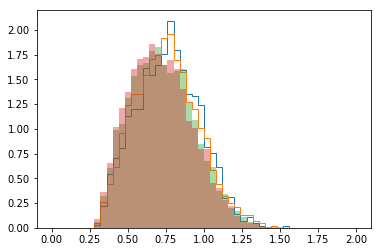

In [21]:
plt.hist(df['C'].query('z>0.5 and missing_mass>1.25')['mass'],bins=50,range=(0,2.0),normed=True,histtype='step')
plt.hist(df['D_C'].query('z>0.5 and missing_mass>1.25')['mass'],bins=50,range=(0,2.0),normed=True,histtype='step')

plt.hist(df['C_mix'].query('z>0.5 and missing_mass>1.25')['mass'],bins=50,range=(0,2.0),normed=True,alpha=0.4)
plt.hist(df['D_C_mix'].query('z>0.5 and missing_mass>1.25')['mass'],bins=50,range=(0,2.0),normed=True,alpha=0.4)
plt.show()

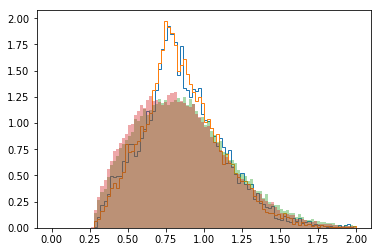

In [16]:
plt.hist(df['C'].query('z>0.5')['mass'],bins=100,range=(0,2.0),normed=True,histtype='step')
plt.hist(df['D_C'].query('z>0.5')['mass'],bins=100,range=(0,2.0),normed=True,histtype='step')

plt.hist(df['C_mix'].query('z>0.5')['mass'],bins=100,range=(0,2.0),normed=True,alpha=0.4)
plt.hist(df['D_C_mix'].query('z>0.5')['mass'],bins=100,range=(0,2.0),normed=True,alpha=0.4)
plt.show()

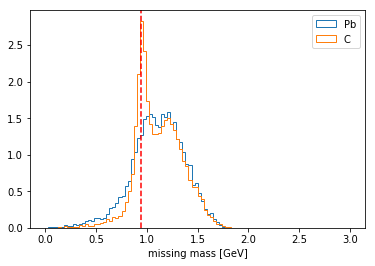

In [20]:
plt.hist(df['C'].query('z>0.5')['missing_mass'],bins=100,range=(0,3.0),normed=True,histtype='step',label='Pb')
plt.hist(df['D_C'].query('z>0.5')['missing_mass'],bins=100,range=(0,3.0),normed=True,histtype='step',label='C')
plt.axvline(x=0.938,color='red',linestyle='--')
plt.xlabel('missing mass [GeV]')
plt.legend()
plt.show()

In [25]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [26]:
to_root(df['Pb'],'Pairs_Pb.root', key='Pb')
to_root(df['Pb_mix'],'Pairs_Pb.root', key='Pb_mix',mode='a')
to_root(df['Pb_trigger'],'Pairs_Pb.root', key='Pb_trigger', mode='a')
to_root(df['D_Pb'],'Pairs_Pb.root', key='D_Pb',mode='a')
to_root(df['D_Pb_mix'],'Pairs_Pb.root', key='D_Pb_mix',mode='a')
to_root(df['D_Pb_trigger'],'Pairs_Pb.root', key='D_Pb_trigger', mode='a')

In [27]:
to_root(df['Fe'],'Pairs_Fe.root', key='Fe')
to_root(df['Fe_mix'],'Pairs_Fe.root', key='Fe_mix',mode='a')
to_root(df['Fe_trigger'],'Pairs_Fe.root', key='Fe_trigger', mode='a')
to_root(df['D_Fe'],'Pairs_Fe.root', key='D_Fe',mode='a')
to_root(df['D_Fe_mix'],'Pairs_Fe.root', key='D_Fe_mix',mode='a')
to_root(df['D_Fe_trigger'],'Pairs_Fe.root', key='D_Fe_trigger', mode='a')

In [28]:
to_root(df['C'],'Pairs_C.root', key='C')
to_root(df['C_mix'],'Pairs_C.root', key='C_mix',mode='a')
to_root(df['C_trigger'],'Pairs_C.root', key='C_trigger', mode='a')
to_root(df['D_C'],'Pairs_C.root', key='D_C',mode='a')
to_root(df['D_C_mix'],'Pairs_C.root', key='D_C_mix',mode='a')
to_root(df['D_C_trigger'],'Pairs_C.root', key='D_C_trigger', mode='a')